In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
train_dir = "./Pumpkin/Original Dataset/"
val_dir = "./Pumpkin/Augmented/valid"
test_dir = "./Pumpkin/Augmented/test"

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

auto_transforms = weights.transforms()

In [6]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# import torchvision.transforms as transforms
# from torchvision.transforms import InterpolationMode

# auto_transforms = transforms.Compose([
#     transforms.RandomRotation(30), 
#     transforms.RandomHorizontalFlip(),
#     transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
#     transforms.RandomCrop(224),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),  
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# ])

In [8]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=auto_transforms,
                                  target_transform=None)

val_data = datasets.ImageFolder(root=val_dir,
                                 transform=auto_transforms,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms,
                                 target_transform=None)

In [ ]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(dataset=train_data,
                               batch_size=10,
                               shuffle=True,
                               num_workers=0,
                               pin_memory=True)

test_data_loader = DataLoader(dataset=test_data,
                               batch_size=10,
                               shuffle=False,
                               num_workers=0,
                               pin_memory=True)

val_data_loader = DataLoader(dataset=val_data,
                               batch_size=10,
                               shuffle=False,
                               num_workers=0,
                               pin_memory=True)

In [10]:
class_names = train_data.classes
class_names, len(class_names)

(['Bacterial Leaf Spot',
  'Downy Mildew',
  'Healthy Leaf',
  'Mosaic Disease',
  'Powdery_Mildew'],
 5)

In [11]:
import os

if not os.path.exists("old_results"):
    os.mkdir("old_results")

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

for param in list(model.features.parameters())[-7:]:
    param.requires_grad = True
    
torch.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
# from torchinfo import summary

# summary(model, input_size=(1, 3, 224, 224))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=5e-4, 
                             weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
#                                                        mode="min", 
#                                                        factor=0.1, 
#                                                        patience=7)

In [15]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_true) * 100

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="old_runs")

In [ ]:
from tqdm.auto import tqdm

epochs = 10
# patience = 10
# early_stop = 0
best_loss = None

for epoch in tqdm(range(1, epochs + 1)):
    
    old_lr = optimizer.param_groups[0]['lr']
    
    model.train()
    train_acc, train_loss = 0, 0
    for batch, (X, y) in tqdm(
        enumerate(train_data_loader),
        desc=f"Training -> Epoch {epoch}",
        total=len(train_data_loader),
        leave=False,
    ):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        train_acc += acc_fn(y, logits.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_acc /= len(train_data_loader)
    train_loss /= len(train_data_loader)

    model.eval()
    val_acc, val_loss = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in tqdm(
            enumerate(val_data_loader),
            desc=f"Validating -> Epoch {epoch}",
            total=len(val_data_loader),
            leave=False,
        ):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            val_loss += loss.item()
            val_acc += acc_fn(y, logits.argmax(dim=1))
    
    val_acc /= len(val_data_loader)
    val_loss /= len(val_data_loader)

    # scheduler.step(val_loss)

    new_lr = optimizer.param_groups[0]['lr']
    
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"Train": train_acc, "Val": val_acc}, global_step=epoch)
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"Train": train_loss, "Val": val_loss}, global_step=epoch)
    writer.add_scalar(tag="Learning Rate", scalar_value=optimizer.param_groups[0]['lr'], global_step=epoch)
    
    print(
        f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}"
    )

    if new_lr < old_lr:
        print(f"Epoch: {epoch} -> learning rate reduced from: {old_lr} to {new_lr}")
        
    info = f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}\n"

    with open("./old_results/training_info.txt", "a") as f:
        f.write(info)

    if best_loss is None:
        best_loss = val_loss
        print(f"Best model saved after epoch: {epoch}")
        torch.save(model, "./old_results/model.pth")

    if val_loss < best_loss:
        best_loss = val_loss
        early_stop = 0
        torch.save(model, "./old_results/model.pth")
        print(f"Best model saved after epoch: {epoch}")
    # else:
    #     early_stop += 1
    #     if early_stop == patience:
    #         print("Early stopping triggered")
    #         break

In [ ]:
test_preds = []

model = torch.load("./old_results/model.pth", weights_only=False)
model.eval()
test_loss, test_acc = 0, 0
with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Testing", leave=False):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        y_pred = logits.argmax(dim=1)
        test_preds.append(y_pred.cpu())
        test_loss += loss_fn(logits, y).item()
        test_acc += acc_fn(y, logits.argmax(dim=1))

test_loss /= len(test_data_loader)       
test_acc /= len(test_data_loader)       
    
test_preds = torch.cat(test_preds)

test_loss, test_acc

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

(0.3543979966081679, 86.5)

In [19]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cm = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
conf_mat = cm(test_preds, torch.Tensor(test_data.targets).type(torch.int64))

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat.numpy(), class_names=class_names, figsize=(7, 7))
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("./old_results/confusion_matrix.png", dpi=1000)

<Figure size 300x300 with 0 Axes>

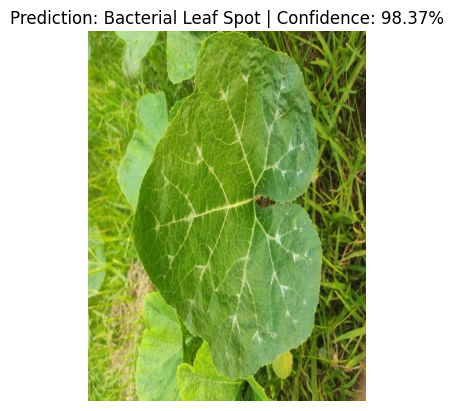

<Figure size 300x300 with 0 Axes>

In [71]:
from PIL import Image

img = Image.open("./Pumpkin/Augmented/test/Bacterial Leaf Spot/Bacterial-Leaf-Spot-291-_jpg.rf.8f82f9b0e084fd9d4ebfc2fb23fc5700.jpg")
img_t = auto_transforms(img).unsqueeze(dim=0)

with torch.inference_mode():
    logits = model(img_t)
    probs = torch.softmax(logits, dim=1)
    max_prob = probs.max()
    label = class_names[logits.argmax(dim=1)]
    
plt.title(f"Prediction: {label} | Confidence: {max_prob * 100:.2f}%")
plt.imshow(img)
plt.axis("off")
plt.figure(figsize=(3, 3))    